In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from utils import *

### Plotting settings

In [2]:
from matplotlib import rcParams

rcParams['text.usetex'] = True
rcParams['axes.formatter.useoffset'] = False

import matplotlib
matplotlib.rc('xtick', labelsize = 16) 
matplotlib.rc('ytick', labelsize = 16)

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern Roman'})

## GWFish

## GWFish + Priors

In [3]:
PATH_TO_RESULTS = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/'
PATH_TO_PLOTS = '/Users/ulyanadupletsa/Documents/PhDThesisPlots/plots/chapter3/'
PATH_TO_POSTERIORS_AVERAGED = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/posterior_samples_averaged/'
PATH_TO_POSTERIORS_m1m2 = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/posterior_samples_averaged_uniform_in_m12_prior/'
PATH_TO_INFO = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/info/'
PATH_TO_LVK_SAMPLES = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/posterior_samples/lvk_samples/'
PATH_TO_GWFISH_AVERAGED = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/gwfish_averaged/'

In [4]:
waveform = 'IMRPhenomXPHM'
events = np.loadtxt(PATH_TO_INFO + 'events_wf_median_priors_%s.txt' %waveform, dtype=str)
with open(PATH_TO_INFO + 'detectors_dictionary.pkl', 'rb') as f:
    detectors = pickle.load(f)
# order events in the events list by date referring to the number in labels.append(event.split('-')[3][0:8])
events_tag = []
for event in events:
    events_tag.append(event.split('-')[3][0:8])

naming_df = pd.DataFrame({'event': events, 'tag': events_tag})
naming_df = naming_df.sort_values(by='tag')
ordered_events = naming_df['event'].values
params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 
            'geocent_time', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']
confidence_level = 90 # number between 0 and 100

In [5]:
cl90_lvk = {}
for event in ordered_events:
    samples_lvk = pd.read_hdf(PATH_TO_LVK_SAMPLES + 'lvk_samples_%s.hdf5' %(event))
    cl90_lvk[event] = get_confidence_interval(samples_lvk, params, confidence_level)

cl90_fisher = {}
cl90_fisher_plus_priors = {}

for event in ordered_events:
    cl90_fisher_one_ev = {}
    cl90_fisher_plus_priors_one_ev = {}

    for i in range(30):
        samples_fisher = pd.read_hdf(PATH_TO_POSTERIORS_AVERAGED + 'fisher_samples/fisher_samples_%s_%s.hdf5' %(event, i))
        cl90_fisher_one_ev[i] = get_confidence_interval(samples_fisher, params, confidence_level)

        samples_fisher_plus_priors = pd.read_hdf(PATH_TO_POSTERIORS_m1m2 + 'fisher_plus_priors_samples/fisher_plus_priors_samples_%s_%s.hdf5' %(event, i))
        cl90_fisher_plus_priors_one_ev[i] = get_confidence_interval(samples_fisher_plus_priors, params, confidence_level)

    cl90_fisher[event] = cl90_fisher_one_ev
    cl90_fisher_plus_priors[event] = cl90_fisher_plus_priors_one_ev

In [6]:
range_summary = {key: [] for key in params}

for param in params:
    range_summary[param] = {key: [] for key in ['gwfish', 'gwfish_plus_priors']}
    for event in ordered_events:
        levels_gwfish = []
        levels_gwfish_plus_priors = []
        for i in range(30):
            levels_gwfish.append((cl90_fisher[event][i][param][1] - cl90_fisher[event][i][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0]))
            levels_gwfish_plus_priors.append((cl90_fisher_plus_priors[event][i][param][1] - cl90_fisher_plus_priors[event][i][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0]))
        range_summary[param]['gwfish'].append(levels_gwfish)
        range_summary[param]['gwfish_plus_priors'].append(levels_gwfish_plus_priors)

In [7]:
num_detectors = {}
for event in ordered_events:
    num_detectors[event] = len(detectors[event])

In [24]:
lbs_errs = ['snr', 'chirp_mass', 'mass_ratio', 'luminosity_distance', 'dec', 'ra', 'theta_jn',
        'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
        'network_optimal_snr',
        'err_chirp_mass', 'err_mass_ratio', 'err_luminosity_distance', 'err_dec', 'err_ra',
        'err_theta_jn', 'err_psi', 'err_phase', 'err_geocent_time', 'err_a_1', 'err_a_2', 'err_tilt_1',
        'err_tilt_2', 'err_phi_12', 'err_phi_jl', 'err_sky_location']

param_label = {'chirp_mass': r'$\mathcal{M}_c$', 'mass_ratio': r'$q$', 'luminosity_distance': r'$d_L$',
                'dec': r'$\texttt{DEC}$', 'ra': r'$\texttt{RA}$', 'theta_jn': r'$\theta_{JN}$', 'psi': r'$\Psi$',
                'phase': r'$\phi$', 'geocent_time': r'$t_c$', 'a_1': r'$a_1$', 'a_2': r'$a_2$',
                'tilt_1': r'$\texttt{tilt}_1$', 'tilt_2': r'$\texttt{tilt}_2$', 'phi_12': r'$\texttt{phi}_{12}$',
                'phi_jl': r'$\texttt{phi}_{JL}$'}

my_palette1 = ['#829595', '#2f4f4f', '#4c7f7f']  #['#97a7a7', '#2f4f4f'] #darkslategray
my_palette2 = ['#eba75f', '#d1781a'] #orange

In [9]:
set_fontsize = 16

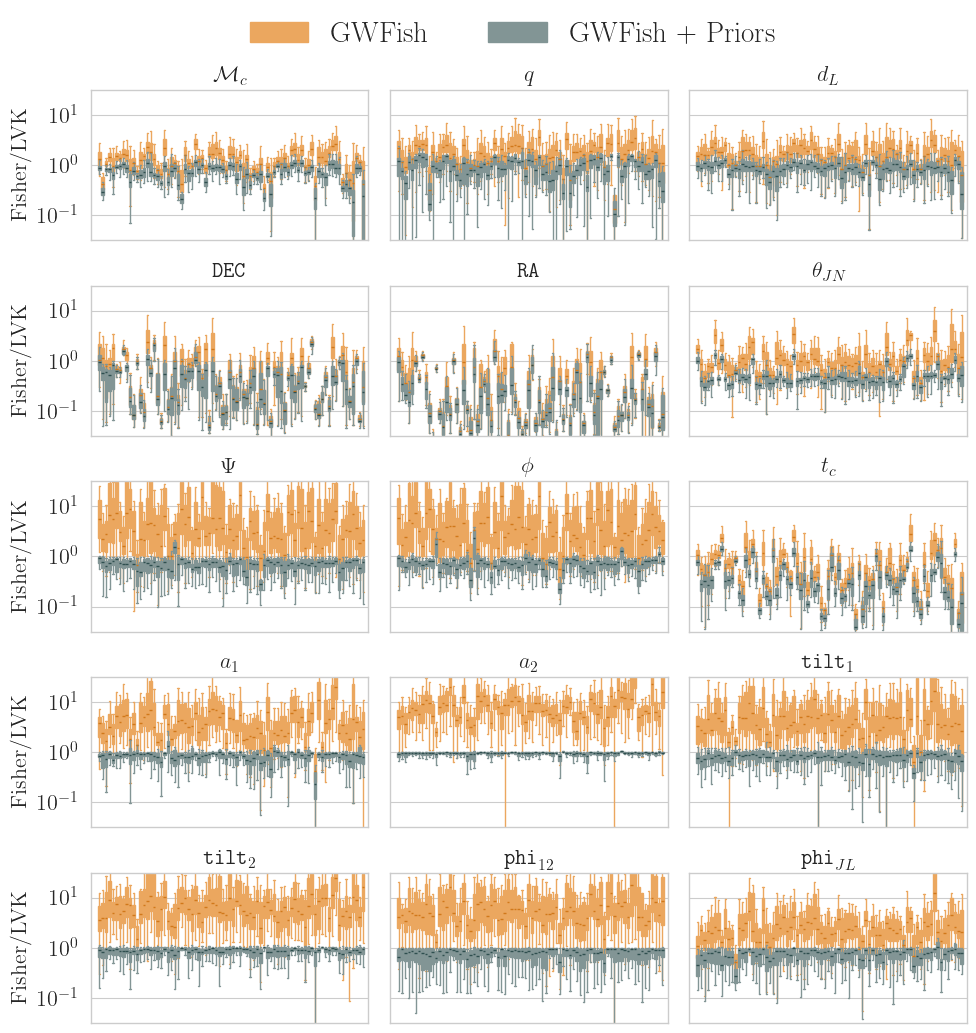

In [25]:
fig, axs = plt.subplots(5, 3, figsize=(10, 10), sharey=True)

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    df = pd.DataFrame(range_summary[param])
    bp1 = ax.boxplot(df['gwfish'], patch_artist=True, 
            boxprops=dict(facecolor=my_palette2[0], color=my_palette2[0]), widths=0.75,
            whiskerprops=dict(color = my_palette2[0]), capprops=dict(color = my_palette2[0]),
            medianprops=dict(color=my_palette2[1]), 
            showfliers=False)
    bp2 = ax.boxplot(df['gwfish_plus_priors'], patch_artist=True, 
            boxprops=dict(facecolor=my_palette1[0], color=my_palette1[0]), widths=0.75,
            whiskerprops=dict(color = my_palette1[0]), capprops=dict(color = my_palette1[0]),
            medianprops=dict(color=my_palette1[1]),
            showfliers=False)

    axs[i//3, 0].set_ylabel('Fisher/LVK', fontsize=set_fontsize)
    ax.set_ylim(10**(-1.5), 10**(1.5))
    ax.set_xlim(-1.5, 79.5)
    ax.set_yscale('log')
    ax.axes.get_xaxis().set_visible(False)
    ax.set_title('%s' %param_label[param], fontsize=set_fontsize, weight='bold')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)

fig.legend([bp1["boxes"][0], bp2["boxes"][0]], ['GWFish', 'GWFish + Priors'], 
                 fontsize=21, bbox_to_anchor=(0.525, 1.01), loc='center', 
                 ncol = 2, frameon=False)
plt.subplots_adjust(wspace=0.01, 
                    hspace=0.2)
plt.tight_layout()
plt.savefig(PATH_TO_PLOTS + 'summary_plot_averaged.pdf', bbox_inches='tight')
plt.show()

In [11]:
median_summary = {key: [] for key in params}

for param in params:
    median_summary[param] = {key: [] for key in ['gwfish', 'gwfish_plus_priors']}
    for event in ordered_events:
        levels_gwfish = []
        levels_gwfish_plus_priors = []
        for i in range(30):
            levels_gwfish.append((cl90_fisher[event][i][param][1] - cl90_fisher[event][i][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0]))
            levels_gwfish_plus_priors.append((cl90_fisher_plus_priors[event][i][param][1] - cl90_fisher_plus_priors[event][i][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0]))
        median_summary[param]['gwfish'].append(np.median(levels_gwfish))
        median_summary[param]['gwfish_plus_priors'].append(np.median(levels_gwfish_plus_priors))

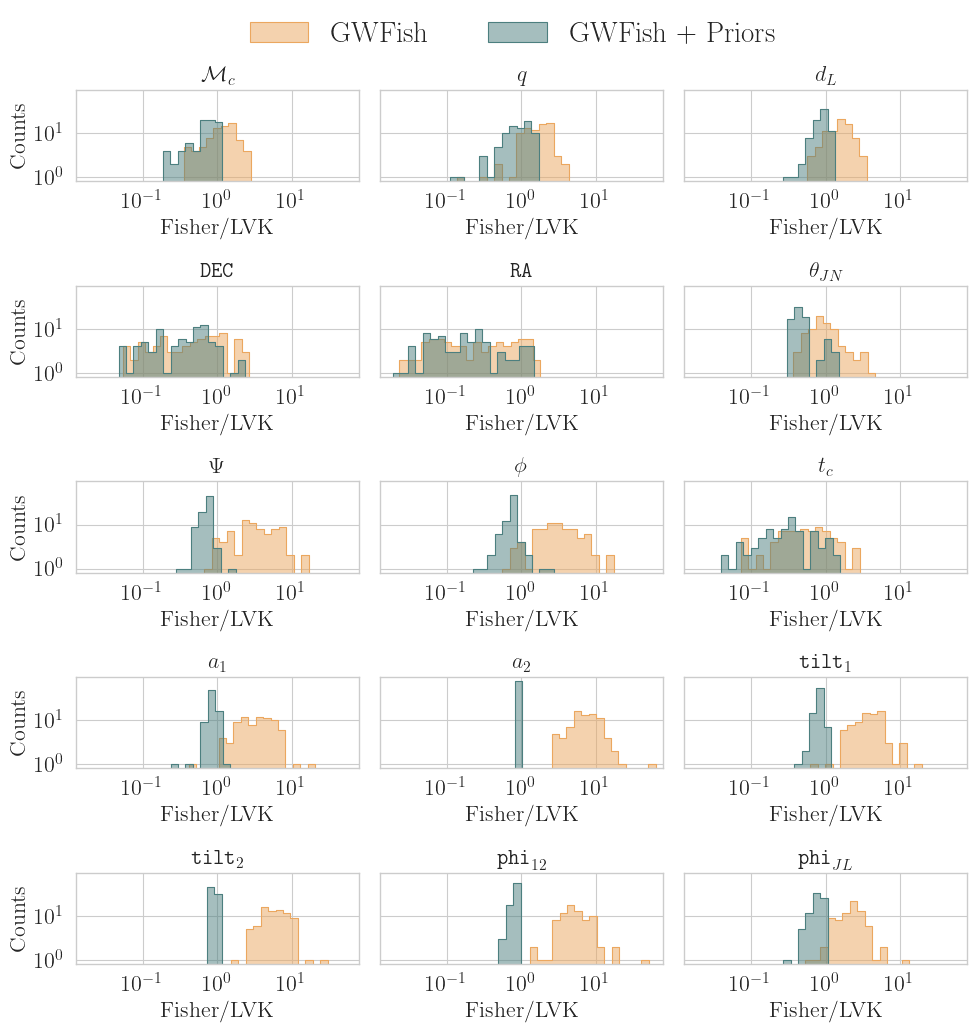

In [26]:
# plot histograms of the median values
fig, axs = plt.subplots(5, 3, figsize=(10, 10), sharex=False, sharey=True)

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax = sns.histplot(median_summary[param]['gwfish'], log_scale=True, binwidth=0.1, element='step', ax=ax, label='GWFish', alpha = 0.5, color = my_palette2[0])
    ax = sns.histplot(median_summary[param]['gwfish_plus_priors'], log_scale=True, binwidth=0.1, element='step', ax=ax, label='GWFish + Priors', alpha=0.5, color = my_palette1[2])
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.set_xlabel('Fisher/LVK', fontsize=set_fontsize)
    ax.set_ylabel('Counts', fontsize=set_fontsize)
    ax.set_xlim(10**(-1.9), 10**(1.9))
    ax.set_title('%s' %param_label[param], fontsize=set_fontsize, weight='bold')


fig.legend(['GWFish', 'GWFish + Priors'],
            fontsize=21, bbox_to_anchor=(0.525, 1.01), loc='center', 
            ncol = 2, frameon=False)    
plt.subplots_adjust(wspace=0.01, 
                    hspace=0.2)
plt.tight_layout()
plt.savefig(PATH_TO_PLOTS + 'summary_plot_averaged_median.pdf', bbox_inches='tight')

plt.show()

In [13]:
total_mass_median = []
active_detectors = []
snr_median = []

for event in ordered_events:
    active_detectors.append(num_detectors[event])

    label_err = get_label(detectors, event,'averaged', 0, 'errors')
    data = pd.read_csv(PATH_TO_GWFISH_AVERAGED + event + '/' + label_err, names = lbs_errs, delimiter=' ', skiprows=1)

    m1, m2 = from_mChirp_q_to_m1_m2(data['chirp_mass'], data['mass_ratio'])
    total_mass_median.append(np.median(m1 + m2))

    snr_median.append(np.median(data['snr']))

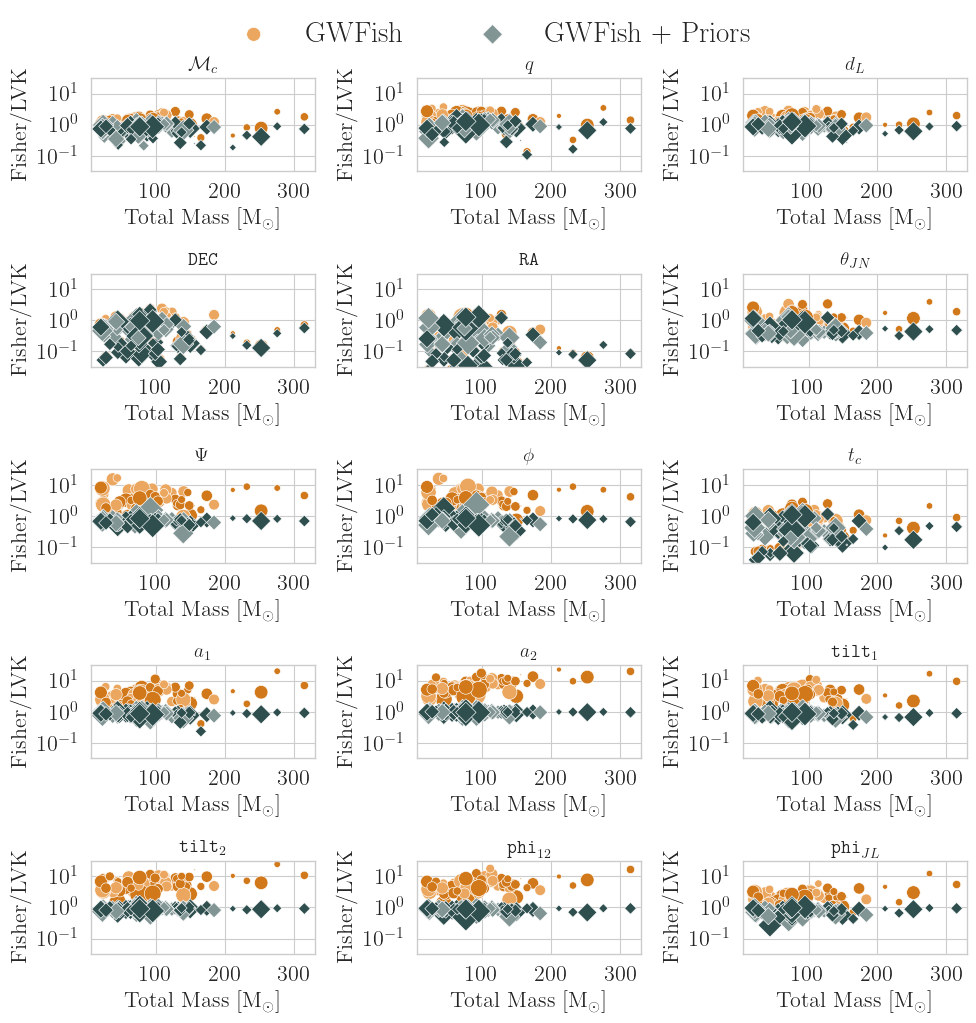

In [27]:
fig, axs = plt.subplots(5, 3, figsize=(10, 10))

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax = sns.scatterplot(x = total_mass_median, y = median_summary[param]['gwfish'], hue = active_detectors, 
                    sizes=(1, 200), palette=sns.color_palette(my_palette2), size=snr_median,
                    legend = False, ax = ax)
    ax = sns.scatterplot(x = total_mass_median, y = median_summary[param]['gwfish_plus_priors'], 
                         hue = active_detectors, sizes=(1, 200), palette=sns.color_palette(my_palette1[0:2]),
                         size=snr_median, marker='D', legend = False, ax = ax)
    ax.set_xlabel('Total Mass [M$_{\odot}$]', fontsize=set_fontsize)
    ax.set_ylabel('Fisher/LVK', fontsize=set_fontsize)
    ax.set_ylim(10**(-1.5), 10**(1.5))
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.set_title('%s' %param_label[param], fontsize=14, weight='bold')
fig.legend(['GWFish', 'GWFish + Priors'], fontsize=21, bbox_to_anchor=(0.5, 1.), loc='center', ncol = 2, frameon=False)


plt.tight_layout()
plt.savefig(PATH_TO_PLOTS + 'summary_plot_median.pdf', bbox_inches='tight')
plt.show()

In [15]:
all_det_events_list = [#'IGWN-GWTC2p1-v2-GW170814_103043_PEDataRelease_mixed_cosmo',
                     #'IGWN-GWTC2p1-v2-GW170818_022509_PEDataRelease_mixed_cosmo',
                     'IGWN-GWTC2p1-v2-GW190701_203306_PEDataRelease_mixed_cosmo',
                     'IGWN-GWTC3p0-v2-GW200202_154313_PEDataRelease_mixed_cosmo',
                     #'IGWN-GWTC3p0-v2-GW200208_222617_PEDataRelease_mixed_cosmo',
                     'IGWN-GWTC3p0-v2-GW200224_222234_PEDataRelease_mixed_cosmo',
                     'IGWN-GWTC3p0-v2-GW200311_115853_PEDataRelease_mixed_cosmo']

In [16]:
total_mass_median_3det = []
active_detectors_3det = []
snr_median_3det = []

for event in all_det_events_list:
    active_detectors_3det.append(num_detectors[event])

    label_err = get_label(detectors, event,'averaged', 0, 'errors')
    data = pd.read_csv(PATH_TO_GWFISH_AVERAGED + event + '/' + label_err, names = lbs_errs, delimiter=' ', skiprows=1)

    m1, m2 = from_mChirp_q_to_m1_m2(data['chirp_mass'], data['mass_ratio'])
    total_mass_median_3det.append(np.median(m1 + m2))

    snr_median_3det.append(np.median(data['snr']))

In [17]:
median_summary_3det = {key: [] for key in params}

for param in params:
    median_summary_3det[param] = {key: [] for key in ['gwfish', 'gwfish_plus_priors']}
    for event in all_det_events_list:
        levels_gwfish = []
        levels_gwfish_plus_priors = []
        for i in range(30):
            levels_gwfish.append((cl90_fisher[event][i][param][1] - cl90_fisher[event][i][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0]))
            levels_gwfish_plus_priors.append((cl90_fisher_plus_priors[event][i][param][1] - cl90_fisher_plus_priors[event][i][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0]))
        median_summary_3det[param]['gwfish'].append(np.median(levels_gwfish))
        median_summary_3det[param]['gwfish_plus_priors'].append(np.median(levels_gwfish_plus_priors))

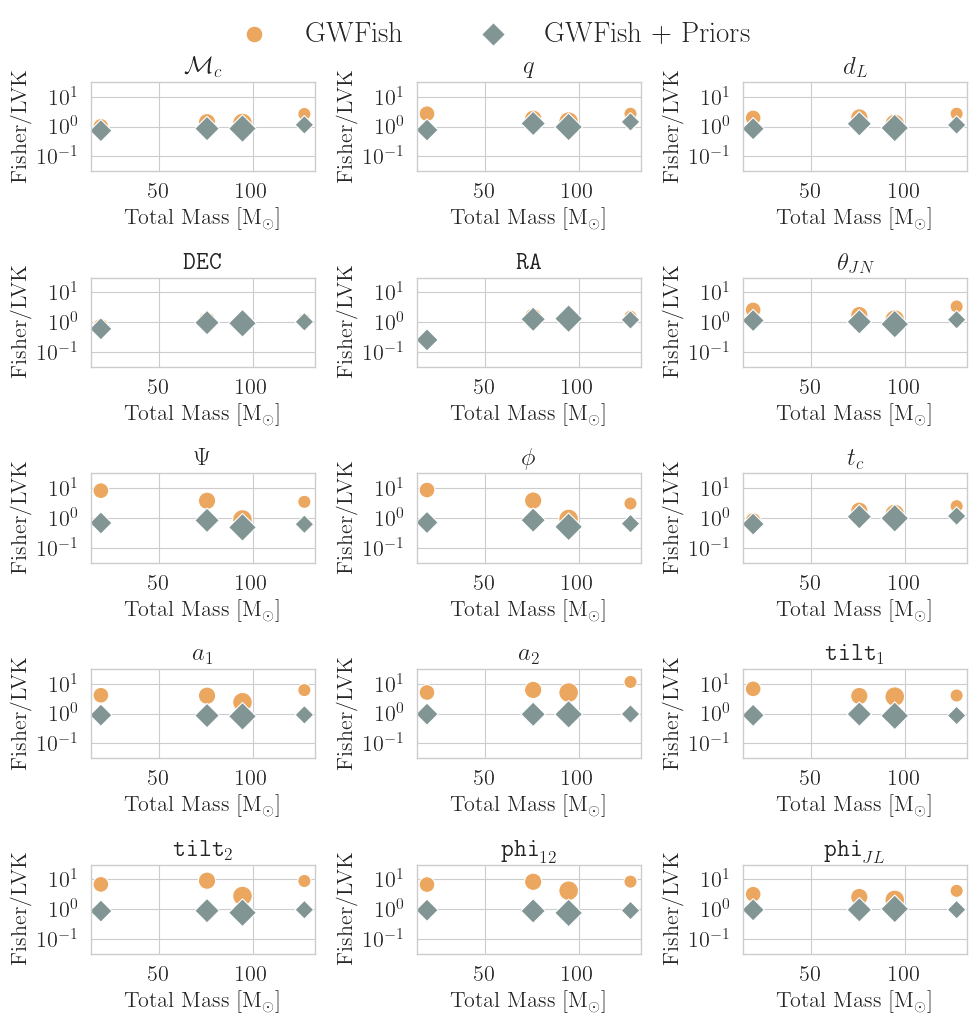

In [28]:
fig, axs = plt.subplots(5, 3, figsize=(10, 10))

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax = sns.scatterplot(x = total_mass_median_3det, y = median_summary_3det[param]['gwfish'],# hue = active_detectors_3det, 
                    sizes=(90, 200), color = my_palette2[0], size=snr_median_3det,
                    legend = False, ax = ax)
    ax = sns.scatterplot(x = total_mass_median_3det, y = median_summary_3det[param]['gwfish_plus_priors'], 
                         #hue = active_detectors_3det, 
                         sizes=(90, 200), color = my_palette1[0],
                         size=snr_median_3det, marker='D', legend = False, ax = ax)
    ax.set_xlabel('Total Mass [M$_{\odot}$]', fontsize=set_fontsize)
    ax.set_ylabel('Fisher/LVK', fontsize=set_fontsize)
    ax.set_ylim(10**(-1.5), 10**(1.5))
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.set_title('%s' %param_label[param], fontsize=18, weight='bold')
fig.legend(['GWFish', 'GWFish + Priors'], fontsize=21, bbox_to_anchor=(0.5, 1.), loc='center', ncol = 2, frameon=False)


plt.tight_layout()
plt.savefig(PATH_TO_PLOTS + 'summary_plot_median_3det.pdf', bbox_inches='tight')
plt.show()

#### Plot GW150914

In [19]:
PATH_TO_INJECTIONS = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/injections/'
PATH_TO_POSTERIORS = '/Users/ulyanadupletsa/Documents/Paper2_Review/results/posterior_samples/'


event = 'IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo'

param_unit = {'chirp_mass': r'[$M_{\odot}$]', 'mass_ratio': r'', 'luminosity_distance': r'[Mpc]',
                'dec': r'[rad]', 'ra': r'[rad]', 'theta_jn': r'[rad]', 'psi': r'[rad]',
                'phase': r'[rad]', 'geocent_time': r'[s]', 'a_1': r'', 'a_2': r'',
                'tilt_1': r'[rad]', 'tilt_2': r'[rad]', 'phi_12': r'[rad]',
                'phi_jl': r'[rad]'}

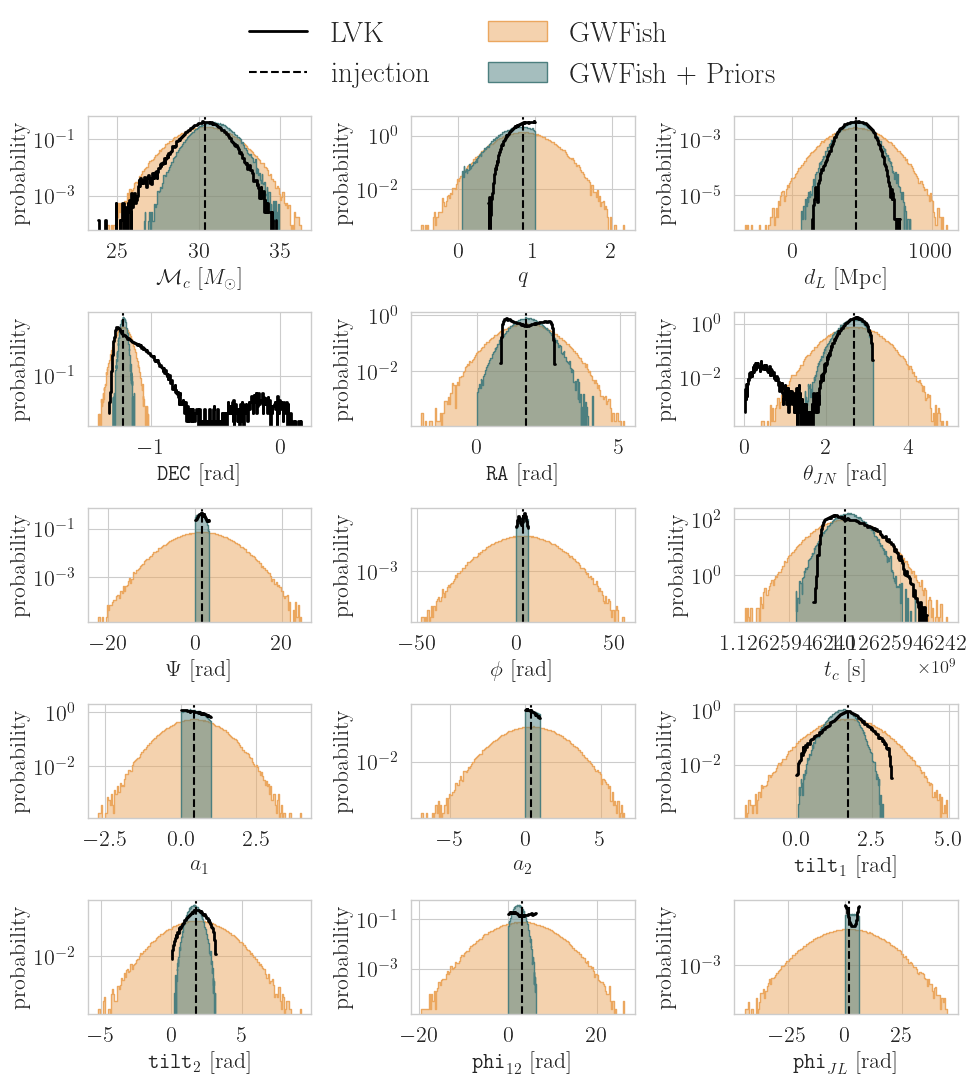

In [21]:
estimator = 'median'

injections = pd.read_hdf(PATH_TO_INJECTIONS + event + '/%s_%s_%s.hdf5' %(event, waveform, estimator))
lvk_samples = pd.read_hdf(PATH_TO_POSTERIORS + 'lvk_samples/lvk_samples_%s.hdf5' %event)
fisher_samples = pd.read_hdf(PATH_TO_POSTERIORS + 'fisher_samples/fisher_samples_%s_%s.hdf5' %(estimator, event))
fisher_plus_priors_samples = pd.read_hdf(PATH_TO_POSTERIORS + 'fisher_plus_priors_samples/fisher_plus_priors_samples_%s_%s.hdf5' %(estimator, event))

fig, axs = plt.subplots(5, 3, figsize=(10, 10))
#fig.suptitle(r'$\texttt{GW150914}$', fontsize=20)

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax = sns.histplot(lvk_samples[param], stat='density', element='step', ax=ax, 
                    label='LVK', alpha = 1., color = 'black', linewidth=2., fill=False)
    ax.axvline(injections[param].values[0], color='black', linestyle = 'dashed', label = 'injection', linewidth=1.5)
    ax = sns.histplot(fisher_samples[param], stat='density', element='step', 
                    ax=ax, label='Fisher', alpha = 0.5, color = my_palette2[0], linewidth=1.)
    ax = sns.histplot(fisher_plus_priors_samples[param], stat='density', element='step', 
                    ax=ax, label='Fisher + Priors', alpha=0.5, color = my_palette1[1], linewidth=1.)
    
    ax.set_ylabel('probability', fontsize=set_fontsize)
    ax.set_xlabel('%s %s' %(param_label[param], param_unit[param]), fontsize=set_fontsize)
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    #ax.legend(fontsize=9)
fig.legend(labels=['LVK', 'injection', 'GWFish', 'GWFish + Priors'], fontsize=21, bbox_to_anchor=(0.815,1.1), ncol = 2, frameon=False)
fig.tight_layout()
plt.savefig(PATH_TO_PLOTS + 'samples_comparison_%s_%s.pdf' %(estimator, event), bbox_inches='tight')
plt.show()